In [12]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_from_ckpt_path
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm

from src.utils import *

In [13]:
plt.style.use('ggplot')

In [14]:
cmap = plt.get_cmap('viridis')

In [15]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [16]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = None
    old_n_components = 0
    print("Initializing datamodule")

# Functions

In [17]:

def linear_padding(x, interp_size = 10):

    first_2_points = x[:,:2,:,:]  
    last_2_points = x[:,-2:,:,:]  
    
    start_pad = torch.zeros(x.size(0), interp_size, x.size(2), x.size(3), device = x.device)  
    end_pad = torch.zeros(x.size(0), interp_size, x.size(2), x.size(3), device = x.device)  
    
    
    for i in range(0,interp_size):
        start_pad[:, -(i+1),:,:] = first_2_points[:, 0,:,:] + (i+1) * (first_2_points[:, 0,:,:] - first_2_points[:, 1,:,:])
        end_pad[:, i,:,:] = last_2_points[:, -1,:,:] + (i+1) * (last_2_points[:, -1,:,:] - last_2_points[:, -2,:,:]) 

    padded_x = torch.cat([start_pad, x, end_pad], dim=1) 
    
    return padded_x

In [18]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [19]:
def loading_datamodule_phase(dm, device = "cpu", phase = "fit"):
    
    dm = hydra.utils.call(cfg.datamodule) 
    dm.setup(stage = phase) 
    
    if phase == "fit": 
        ssp_ds = dm.train_dataloader().dataset.input

    elif phase == "test":
        ssp_ds = dm.test_dataloader().dataset.input
      
        
    ssp_arr = ssp_ds.dropna(dim='lat').data
    ssp_tens = torch.tensor(ssp_arr).float().to(device)
    
    coords = ssp_ds.coords

                
    return ssp_arr, ssp_tens, dm.norm_stats, coords

In [20]:
def cubic_padding_multi_dim(signal, pad_size, dim=1):
    # pad_size: Number of points to pad at the beginning and end along the specified dimension
    # dim: The dimension along which to perform the padding (default is 1)
    
    # Move the dimension of interest to the first dimension
    signal = signal.transpose(dim, 0)  # Now signal has shape [107, 255, 174, 240]
    original_shape = signal.shape
    L = original_shape[0]  # Length of the dimension along which to pad (107)
    other_dims = original_shape[1:]  # (255, 174, 240)
    #N = torch.prod(torch.tensor(other_dims)).item()  # Total number of signals (255*174*240)
    N = other_dims.numel()
    
    # Flatten the rest of the dimensions
    signal = signal.reshape(L, N)  # Now signal is of shape [107, N]
    
    # Indices along the dimension
    x = torch.arange(L, device=signal.device, dtype=signal.dtype)  # Shape [107]
    
    # # Edge indices
    edge_indices = torch.arange(pad_size, device=signal.device, dtype=torch.long)
    
    # Beginning of the signal
    x_start = x[:pad_size]  # Shape [pad_size]
    #y_start = signal[edge_indices, :]  # Shape [pad_size, N]
    y_start = signal[:pad_size,:]
    
    
    # Fit cubic polynomial at the start
    X_start = torch.stack([x_start**3, x_start**2, x_start, torch.ones_like(x_start)], dim=1)  # Shape [pad_size, 4]
    coeffs_start = torch.linalg.lstsq(X_start, y_start).solution  # Shape [4, N]
    
    # Generate padding for the start
    x_pad_start = x_start - pad_size  # Extrapolate to positions before the signal
    X_pad_start = torch.stack([x_pad_start**3, x_pad_start**2, x_pad_start, torch.ones_like(x_pad_start)], dim=1)  # Shape [pad_size, 4]
    y_pad_start = X_pad_start @ coeffs_start  # Shape [pad_size, N]
    
    # End of the signal
    x_end = x[-pad_size:]  # Shape [pad_size]
    y_end = signal[-pad_size:, :]  # Shape [pad_size, N]
    
    # Fit cubic polynomial at the end
    X_end = torch.stack([x_end**3, x_end**2, x_end, torch.ones_like(x_end)], dim=1)  # Shape [pad_size, 4]
    coeffs_end = torch.linalg.lstsq(X_end, y_end).solution  # Shape [4, N]
    
    # Generate padding for the end
    x_pad_end = x_end + pad_size  # Extrapolate to positions after the signal
    X_pad_end = torch.stack([x_pad_end**3, x_pad_end**2, x_pad_end, torch.ones_like(x_pad_end)], dim=1)  # Shape [pad_size, 4]
    y_pad_end = X_pad_end @ coeffs_end  # Shape [pad_size, N]
    
    # Concatenate padding and original signal
    padded_signal = torch.cat([y_pad_start, signal, y_pad_end], dim=0)  # Shape [L + 2*pad_size, N]
    
    # Reshape back to original dimensions, adjusting for the new size of the padded dimension
    padded_L = L + 2 * pad_size
    padded_signal = padded_signal.reshape(padded_L, *other_dims)  # Shape [padded_L, 255, 174, 240]
    
    # Move the dimension back to its original position
    dims = list(range(padded_signal.dim()))
    dims[0], dims[dim] = dims[dim], dims[0]
    padded_signal = padded_signal.permute(*dims)
    
    return padded_signal

# Load model

In [21]:
verbose = True

ckpt_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE/AE_CNN_3D/[1,1]_trilinear_test_on_padding/pred_1_grad_0/upsample_mode_trilinear/1_conv_per_layer/padding_linear/pooling_Max_on_dim_all/final_upsample_upsample_pooling/act_fn_None_final_act_fn_None/lr_0.001/normalization_min_max/manage_nan_suppress/n_profiles_None/2024-10-10_18-25/checkpoints/val_loss=0.00-epoch=781.ckpt"

    

cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = False)

if dm_dict == None or cfg.datamodule != dm_dict:
    if verbose:
        print("Inititing datamodule; Generating train and test datasets")
    
    dm_dict = cfg.datamodule
    dm = hydra.utils.call(dm_dict)
    _, train_ssp_tens, _, coords = loading_datamodule_phase(dm, phase = "fit")
    
    input_test_shape = train_ssp_tens.shape
    depth_array = coords["z"].data

        
if verbose:
    print("Loading model, generating AE output")          

lit_model = load_model(ckpt_path, device)


ssp_ae_test_arr = lit_model(train_ssp_tens).detach().cpu().numpy()


Inititing datamodule; Generating train and test datasets


Loading model, generating AE output


In [22]:
train_ssp_tens.shape

torch.Size([255, 107, 174, 240])

In [23]:
linear_interp_train_tens = linear_padding(train_ssp_tens, interp_size = 15)

In [24]:
cubic_interp_train_tens = cubic_padding_multi_dim(train_ssp_tens, pad_size=15, dim=1)

In [30]:
constant_pad_train_ssp_tens = torch.nn.functional.pad(train_ssp_tens, (0 , 0, 0, 0, 15, 15), mode = "constant")
reflect_pad_train_ssp_tens = torch.nn.functional.pad(train_ssp_tens, (0 , 0, 0, 0, 15, 15), mode = "reflect")
replicate_pad_train_ssp_tens = torch.nn.functional.pad(train_ssp_tens, (0 , 0, 0, 0, 15, 15), mode = "replicate")
circular_pad_train_ssp_tens = torch.nn.functional.pad(train_ssp_tens, (0 , 0, 0, 0, 15, 15), mode = "circular")

In [31]:
train_ssp_tens.shape

torch.Size([255, 107, 174, 240])

In [32]:
reflect_pad_train_ssp_tens.shape

torch.Size([255, 137, 174, 240])

In [36]:
(reflect_pad_train_ssp_tens[:,15:-15] == train_ssp_tens).all()

tensor(True)

In [33]:
t = 180
lat = 10
lon = 10

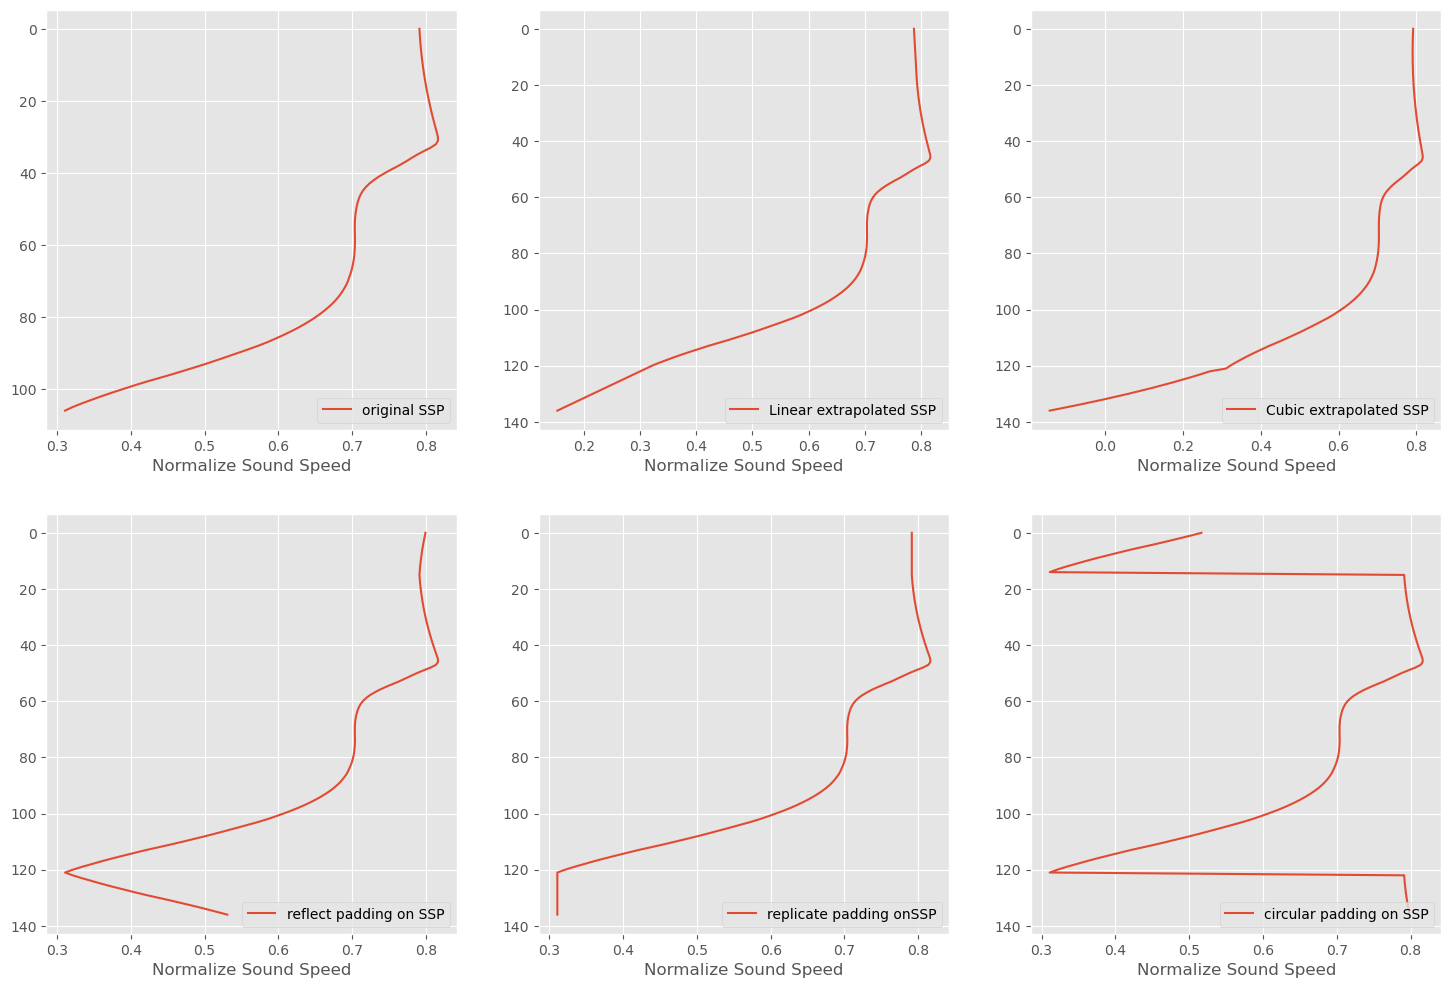

In [34]:
fig,axs = plt.subplots(2,3,figsize=(18,12))
axs[0,0].plot(train_ssp_tens[t,:,lat,lon], np.arange(len(train_ssp_tens[t,:,lat,lon])), label ="original SSP")
axs[0,1].plot(linear_interp_train_tens[t,:,lat,lon],np.arange(len(linear_interp_train_tens[t,:,lat,lon])), label ="Linear extrapolated SSP")
axs[0,2].plot(cubic_interp_train_tens[t,:,lat,lon],np.arange(len(cubic_interp_train_tens[t,:,lat,lon])), label ="Cubic extrapolated SSP")

axs[1,0].plot(reflect_pad_train_ssp_tens[t,:,lat,lon], np.arange(len(reflect_pad_train_ssp_tens[t,:,lat,lon])), label ="reflect padding on SSP")
axs[1,1].plot(replicate_pad_train_ssp_tens[t,:,lat,lon],np.arange(len(replicate_pad_train_ssp_tens[t,:,lat,lon])), label ="replicate padding onSSP")
axs[1,2].plot(circular_pad_train_ssp_tens[t,:,lat,lon],np.arange(len(circular_pad_train_ssp_tens[t,:,lat,lon])), label ="circular padding on SSP")



for ax in axs.ravel()[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Normalize Sound Speed")
    
    ax.invert_yaxis() 
    